## 数据情况
记录了支付宝两组营销策略的活动情况：
* data.csv: 广告点击情况数据集
字段如下：
* dmp_ids：营销策略编号（源数据文档未作说明，这里根据数据情况设定为1：对照组，2：营销策略一，3：营销策略二）
* user_id：支付宝用户ID
* label：用户当天是否点击活动广告（0：未点击，1：点击）

### 数据导入和清洗

In [1]:
# import libraries
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt

In [3]:
#读数据
data = pd.read_csv(r"D:\DA\4.python\3.统计分析\data.csv")
data.head()

,user_id,label,dmp_id
0,1,0,1
1,1000004,0,1
2,1000004,0,2
3,1000006,0,1
4,1000006,0,3


In [4]:
#描述性统计
pd.set_option('display.float_format', '{:.2f}'.format) # 设置全局显示格式，避免科学计数法
data.describe()

,user_id,label,dmp_id
count,2632975.00,2632975.00,2632975.00
mean,3112326.14,0.01,1.40
std,1828223.38,0.12,0.69
min,1.00,0.00,1.00
25%,1526413.00,0.00,1.00
50%,3061415.00,0.00,1.00
75%,4720376.50,0.00,2.00
max,6265402.00,1.00,3.00


In [5]:
data.nunique()  #用户数和记录条数不一致，有重复数据

user_id    2410683
label            2
dmp_id           3
dtype: int64

In [6]:
#重复值处理
data.shape

(2632975, 3)

In [7]:
data.drop_duplicates(subset=["user_id"],inplace=True)
data.shape

(2410683, 3)

In [10]:
#label	dmp_id 异常数据查看
for i in ["label","dmp_id"]:
    print(i,data[i].unique())

label [0 1]
dmp_id [1 3 2]


## 样本容量检验

在进行A/B测试前，需检查样本容量是否满足试验所需最小值。  
这里借助Evan Miller的样本量计算工具：  
[Sample Size Calculator](https://www.evanmiller.org/ab-testing/sample-size.html)  

首先需要设定点击率基准线以及最小提升比例，我们将对照组的点击率设为基准线.

In [11]:
# 对照组的点击率
data[data["dmp_id"] == 1]["label"].mean()

0.012341294690700636

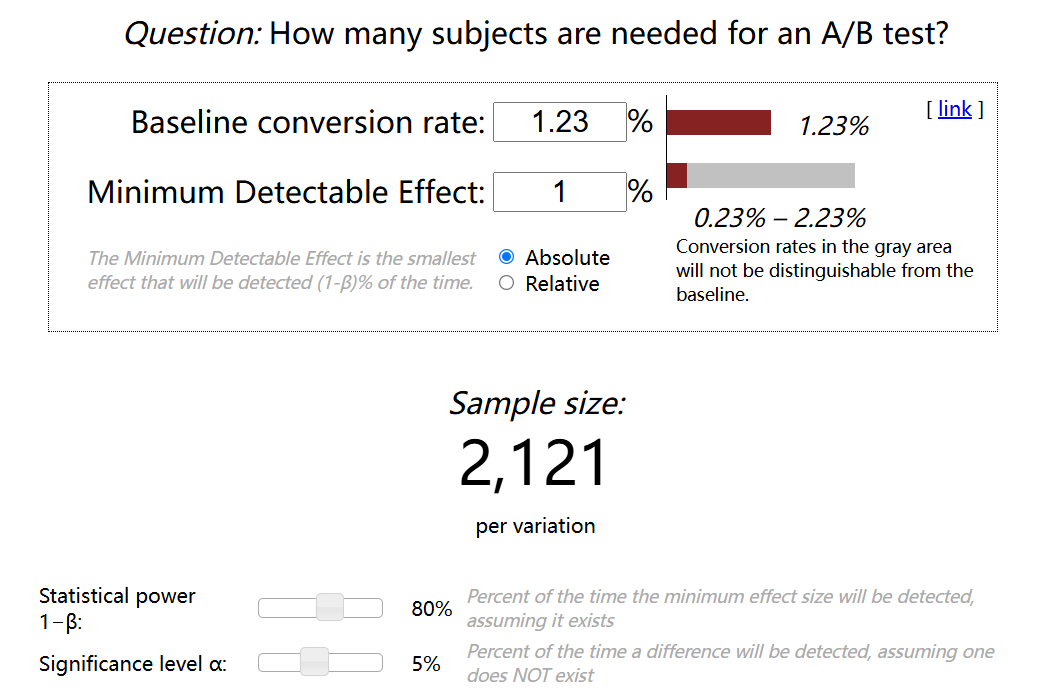

# 样本比例之差 样本量计算公式
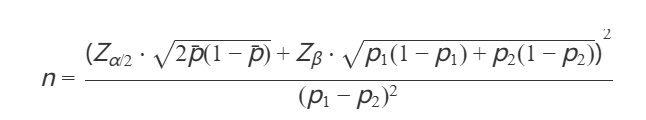   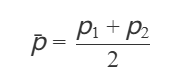

In [32]:
import scipy.stats
# H0：p1=p2,实验无效果
# H1：p1!=p2,两组转化率存在差异但方向未知

p1 = data[data["dmp_id"] == 1]["label"].mean()
dieta = 0.01
p2 = p1 + dieta
p_bar = (p1 + p2) / 2

alpha = 0.05 #有5%的几率犯第一类错误：实际上是H0，但检验结果认为是H1
z_alpha = scipy.stats.norm.ppf(1 - alpha / 2) #因为我们不知道实验效果的方向（可能变好或变差），所以要在两侧都留出拒绝域，双尾检测
print("z_alpha:",z_alpha)
#z_alpha≈1.96：标准正态分布下，95% 的数据落在 ±1.96 之间（双尾）若实际检测到的Z值超过 1.96（或低于 -1.96），可认为差异显著。

beta = 0.2 #有20%的几率犯第二类错误：实际上是H1，但检验结果认为是H0
z_beta = scipy.stats.norm.ppf(1 - beta) #在计算功效时，我们已经假设了一个明确的方向（比如提升 dieta），所以只需单尾检测，比如H₁: p2 > p1，我们只关心右侧的分布。
print("z_beta:",z_beta)
#z_beta: 0.84：标准正态分布下，80% 的数据落在 Z ≤ 0.84 的左侧（单尾），若真实存在差异，则有 80% 的概率能检测到。


# 计算每组的样本量
n_per_group = ((z_alpha * np.sqrt(2 * p_bar * (1 - p_bar)) + z_beta * np.sqrt(p1*(1 - p1) + p2*(1 - p2))) ** 2 / (dieta ** 2))
total_n = 2 * n_per_group  # 总样本量

print("对照组转化率 p1:", p1)
print("预期绝对提升:", dieta)
print("每组所需样本量:", n_per_group)
print("总样本量:", total_n)

z_alpha: 1.959963984540054
z_beta: 0.8416212335729143
对照组转化率 p1: 0.012341294690700636
预期绝对提升: 0.01
每组所需样本量: 2673.80910876864
总样本量: 5347.61821753728


In [33]:
# 各组数据样本量
data["dmp_id"].value_counts()

dmp_id
1    1903528
2     293453
3     213702
Name: count, dtype: int64

两组营销活动的样本量分别为29.34万和21.37万，满足最小样本量需求

In [34]:
# click rate of groups
print("对  照  组： " ,data[data["dmp_id"] == 1]["label"].mean())
print("营销策略一： " ,data[data["dmp_id"] == 2]["label"].mean())
print("营销策略二： " ,data[data["dmp_id"] == 3]["label"].mean())

对  照  组：  0.012341294690700636
营销策略一：  0.017317935069670443
营销策略二：  0.030453622333904223


In [36]:
# 一次性获取所有组的样本量和点击次数
group_stats = data.groupby("dmp_id")["label"].agg(["count", "sum"])
group_stats.columns = ["样本量", "点击次数"]

print(group_stats)

            样本量   点击次数
dmp_id                
1       1903528  23492
2        293453   5082
3        213702   6508


### 双比例Z检验：函数法

In [44]:
from statsmodels.stats.proportion import proportions_ztest

# 对照组和策略二的点击次数与样本量

# 执行双比例Z检验
z_stat, p_value = proportions_ztest([6508,23492], [213702,1903528], alternative='two-sided')
print(f"Z值: {z_stat:.4f}, p值: {p_value:.4g}")

# 判断显著性
alpha = 0.05
if p_value < alpha:
    print("拒绝H0，策略二与对照组的差异显著！")
else:
    print("不拒绝H0，差异不显著。")

Z值: 67.1733, p值: 0
拒绝H0，策略二与对照组的差异显著！


### 双比例Z检验：公式法

In [48]:
# 输入数据（对照组和策略二的点击次数与样本量）
x1, x2 = 23492, 6508      # 点击次数
n1, n2 = 1903528, 213702  # 样本量

# 计算比例 p1, p2 和合并比例 p
p1 = x1 / n1
p2 = x2 / n2
p_pooled = (x1 + x2) / (n1 + n2)  # 合并比例

# 计算标准误差 (Standard Error)
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

# 计算Z统计量
z_score = (p2 - p1) / se

# 计算双尾p值
p_value = 2 * (1 - norm.cdf(np.abs(z_score)))

# 输出结果
print(f"Z值: {z_score:.4f}")
print(f"p值: {p_value:.4g}")

alpha = 0.05
if p_value < alpha:
    print("拒绝H0，策略二与对照组的差异显著！")
else:
    print("不拒绝H0，差异不显著。")

Z值: 67.1733
p值: 0
拒绝H0，策略二与对照组的差异显著！
